## b968 - 30/06/2016 - MONSOON - LST survey

For this example we compare the brightness temperature measurements from the Heimann instrument on the aircraft with land surface temperature data from the MODIS instrument. 

In [1]:
%matplotlib inline

## Reading the MODIS L2 hdf

In [2]:
import cis
modis = cis.read_data('MOD11_L2.A2016182.0535.006.2016241031519.hdf', 'LST', 
                      'MODIS_LST')

In [3]:
print(modis)

Ungridded data: Land-surface Temperature / (K) 
     Shape = (1035351,)

     Total number of points = 1035351
     Number of non-masked points = 1035351
     Long name = Land-surface Temperature
     Standard name = None
     Units = K
     Missing value = 0
     Range = (232.80000000000001, 335.68000000000001)
     History = 
     Misc attributes: 
       Number Type = uint16
       Lst = LST data * scale_factor
       Valid_Range = [7500, 65535]
       Calibrated_Nt = 5
       Scale_Factor_Err = 0.0
       Add_Offset_Err = 0.0
     Coordinates: 
       latitude
          Long name = Latitude of every 5 scan lines and 5 pixels
          Standard name = latitude
          Units = degree
          Missing value = -999.0
          Range = (19.806649210396216, 38.241140424693057)
          History = 
          Misc attributes: 
            Cell_Across_Swath_Sampling = 3, 1353, 5
            Number Type = float32
            Valid_Range = [-90.0, 90.0]
            Cell_Along_Swath_Samplin

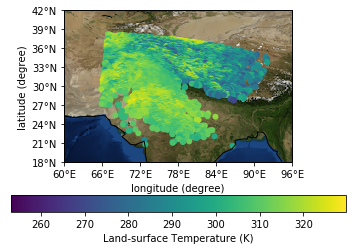

In [4]:
ax = modis[::100].plot()
# add the bluemarble background
ax.bluemarble()

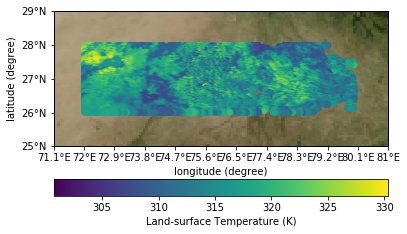

In [5]:
sub_modis = modis.subset(longitude=[72,80], latitude=[26, 28])
ax = sub_modis.plot()
ax.bluemarble()

## Reading in brightness temperature from aircraft

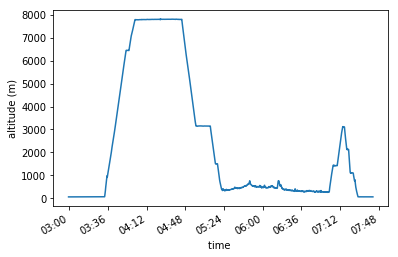

In [6]:
# reading the brightness temperature from the Heimann instrument on the FAAM aircraft
ara_bt = cis.read_data('core_faam_20160630_v004_r0_b968_1hz_editted.nc', 'BTHEIM_U', 
                       product='NCAR_NetCDF_RAF')
ara_bt.plot(xaxis='time', yaxis='altitude')

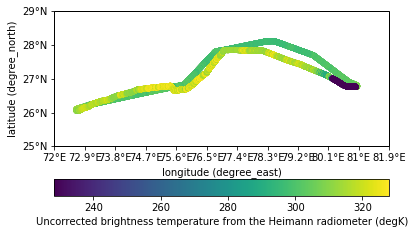

In [7]:
ara_bt.plot()

For the further analysis we are interested in the low level leg which starts at about 05:25Z and ends at 07:00Z. Clipping the brightness data using the subset method.

In [8]:
# Defining start and end time
from datetime import datetime

# create a subset using the start and end time
ara_bt = ara_bt.subset(t=[datetime(2016,6,30,5,25), datetime(2016,6,30,7,0)])

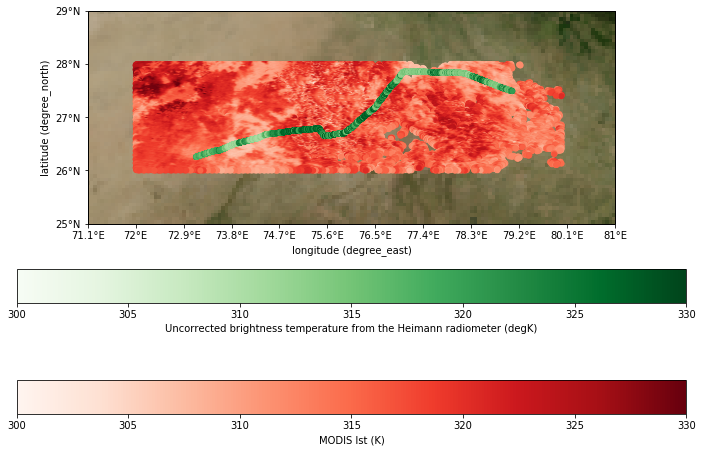

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

sub_modis.plot(ax=ax, label='MODIS lst (K)', cmap='Reds', vmin=300, vmax=330, cbarorient='horizontal')
ara_bt.plot(ax=ax, cmap='Greens', vmin=300, vmax=330, cbarorient='horizontal')
ax.bluemarble()

We can create nice overlays to get a feel for the location and sampling, but if we want to perform a quantitive comparison we'll need to collocate the data

## Collocation

In [10]:
# collocate brightness temperature with MODIS. Note this time we're aggregating the aircraft data
ara_bt_col = ara_bt.collocated_onto(sub_modis, h_sep=1, t_sep='P1D', kernel='mean')

In [11]:
print(ara_bt_col[0].shape)

(108847,)


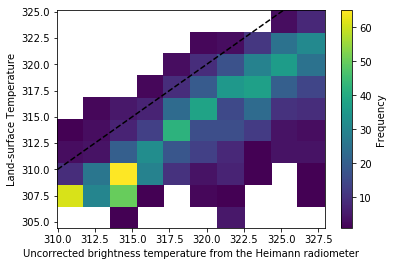

In [12]:
# Append the modis data onto our collocated data so we can plot them together easily
ara_bt_col.append(sub_modis)
ax = ara_bt_col.plot(how='histogram2d')

## Aggregation (group-by)

In [13]:
modis_l3 = cis.read_data('MOD11A1.A2016182.h24v06.006.2016241041630.4326.lst.nc', 'lst')

In [14]:
# Apply scaling (which would be applied if it was in the metadata)
modis_l3.data *= 0.02

In [15]:
print(modis_l3)

GDAL Band Number 1 / (1)            (latitude: 1505; longitude: 2555)
     Dimension coordinates:
          latitude                           x                -
          longitude                          -                x
     Attributes:
          Conventions: CF-1.5
          GDAL: GDAL 1.11.3, released 2015/09/16
          history: Tue May  2 18:55:43 2017: ncrename -v Band1,lst MOD11A1.A2016182.h24v06.006.2016241041630.4326.lst.nc
Tue...


In [16]:
agg_bt = ara_bt.collocated_onto(modis_l3, kernel='mean')
print(agg_bt)

GriddedDataList: 
0: Uncorrected brightness temperature from the Heimann radiometer / (degK) (latitude: 1505; longitude: 2555)


In [17]:
# copy the mask over from the brightness temperature - because of the way we did the 
# collocation, and because we're going to average over all the points next
modis_l3.data.mask |= agg_bt[0].data.mask

In [18]:
agg_bt.append(modis_l3)
print(agg_bt)

GriddedDataList: 
0: Uncorrected brightness temperature from the Heimann radiometer / (degK) (latitude: 1505; longitude: 2555)
1: GDAL Band Number 1 / (1)            (latitude: 1505; longitude: 2555)


In [19]:
ara_bt_col_meridional = agg_bt.collapsed('latitude', how='mean')

/Users/watson-parris/miniconda3/envs/cis_env3/lib/python3.5/site-packages/iris/analysis/cartography.py:368: UserWarning: Assuming spherical earth from ellipsoid.
  warnings.warn("Assuming spherical earth from ellipsoid.")


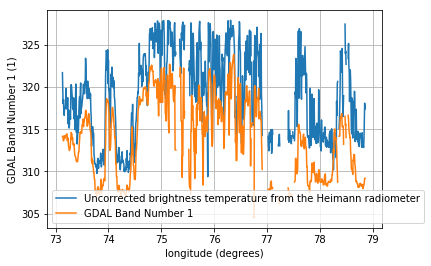

In [20]:
ax=ara_bt_col_meridional.plot()
ax.grid(True)